# Linear Regression

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib

class StudentDataset: 
    def __init__(self, num_students: int, seed: int):
        self.num_students = num_students
        self.rng = np.random.default_rng(seed)
        self.df = self.assemble_dataframe()

    def generate_gender(self) -> list[str]:
        genders = ['Male', 'Female', 'Other']
        probabilities = [0.65, 0.33, 0.02]
        return self.rng.choice(genders, size=self.num_students, p=probabilities).tolist()

    def generate_major(self) -> list[str]:
        majors = ["B.Tech", "MS", "PhD"]
        probabilities = [0.7, 0.2, 0.1]
        return self.rng.choice(majors, size=self.num_students, p=probabilities).tolist()

    def generate_program(self, majors: list[str]) -> list[str]:
        programs = []
        for major in majors:
            if major == "B.Tech":
                programs.append(self.rng.choice(["CSE", "ECE", "CHD", "CND"], p = [0.4, 0.4, 0.1, 0.1]))
            elif major == "MS":
                programs.append(self.rng.choice(["CSE", "ECE", "CHD", "CND"], p = [0.3, 0.3, 0.2, 0.2]))
            elif major == "PhD":
                programs.append(self.rng.choice(["CSE", "ECE", "CHD", "CND"], p = [0.25, 0.25, 0.25, 0.25]))
            
        return programs
    
    def generate_gpa(self, majors: list[str]) -> list[float]:
        gpas = []
        for major in majors:
            if major == "B.Tech":
                gpa = self.rng.normal(7.0, 1.0)
            elif major == "MS":
                gpa = self.rng.normal(8.0, 0.7)
            elif major == "PhD":
                gpa = self.rng.normal(8.3, 0.5)

            gpas.append(np.clip(gpa, 4.0, 10.0))
        return gpas

    def assemble_dataframe(self) -> pd.DataFrame:
        majors = self.generate_major()
        programs = self.generate_program(majors)
        gpas = self.generate_gpa(majors)

        df = pd.DataFrame({
            "gender": self.generate_gender(),
            "major": majors,
            "program": programs,    
            "GPA": gpas
        })
        return df

    def get_full_dataframe(self) -> pd.DataFrame:
        return self.df

   gender   major program       GPA
0    Male  B.Tech     ECE  7.695391
1  Female      MS     CSE  8.403801
2    Male      MS     ECE  9.033050
3    Male     PhD     CND  7.932776
4  Female      MS     ECE  8.230006


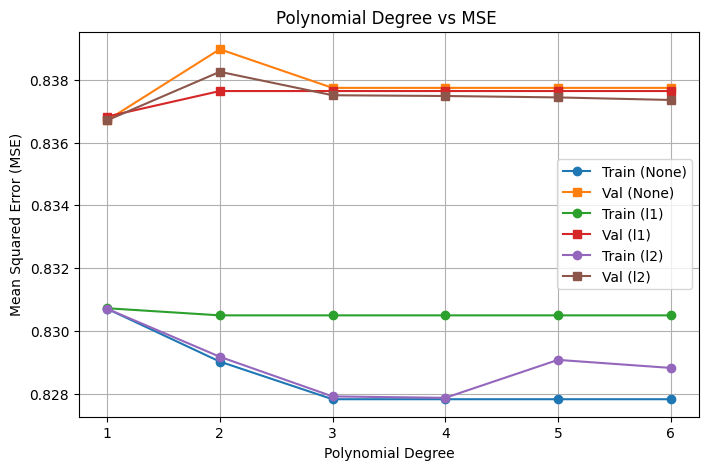

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def run_poly_regression(X_train, y_train,
                        X_val, y_val,
                        X_test, y_test,
                        degree=1,
                        regularizer=None,
                        reg_strength=0.0):
    """
    Fit a polynomial regression model with optional regularization.
    """
    # Polynomial expansion
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    # Standardization
    scaler = StandardScaler()
    X_train_poly = scaler.fit_transform(X_train_poly)
    X_val_poly = scaler.transform(X_val_poly)
    X_test_poly = scaler.transform(X_test_poly)

    # Choose model
    if regularizer is None:
        model = LinearRegression()
    elif regularizer == 'l1':
        model = Lasso(alpha=reg_strength, max_iter=5000)
    elif regularizer == 'l2':
        model = Ridge(alpha=reg_strength)
    else:
        raise ValueError("Invalid regularizer. Choose from None, 'l1', or 'l2'.")

    # Train
    model.fit(X_train_poly, y_train)

    # Compute MSE
    train_mse = mean_squared_error(y_train, model.predict(X_train_poly))
    val_mse = mean_squared_error(y_val, model.predict(X_val_poly))
    test_mse = mean_squared_error(y_test, model.predict(X_test_poly))

    return {
        'train_mse': train_mse,
        'val_mse': val_mse,
        'test_mse': test_mse,
        'coefficients': model.coef_,
    }

if __name__ == "__main__":

    username = "peketivenkata.v"
    seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
    dataset = StudentDataset(num_students=10000, seed=seed)
    df = dataset.get_full_dataframe()
    print(df.head())

    X = df.drop(columns=['GPA'])  
    y = df['GPA']                 

    encoder = OneHotEncoder(sparse_output=False, drop='first')
    X_encoded = pd.DataFrame(encoder.fit_transform(X),
                             columns=encoder.get_feature_names_out(X.columns))

    # Split: 60% train, 20% val, 20% test
    X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.4, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

    degrees = [1, 2, 3, 4, 5, 6]
    regularizers = [None, 'l1', 'l2']
    reg_strengths = np.logspace(-3, 3, 7)
    results = {}

    plt.figure(figsize=(8, 5))

    for reg in regularizers:
        train_mses = []
        val_mses = []
        results[reg] = []

        for degree in degrees:
            if reg is None:
                # No regularization
                res = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test, degree=degree)
            else:
                # With regularization - choose best alpha
                best_val_mse = float('inf')
                best_alpha = None
                best_res = None
                for alpha in reg_strengths:
                    res = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                                            degree=degree, regularizer=reg, reg_strength=alpha)
                    if res["val_mse"] < best_val_mse:
                        best_val_mse = res["val_mse"]
                        best_alpha = alpha
                        best_res = res
                best_res["best_alpha"] = best_alpha
                res = best_res

            results[reg].append(res)
            train_mses.append(res['train_mse'])
            val_mses.append(res['val_mse'])

        # Plot each regularizer's MSE trend
        
        plt.plot(degrees, train_mses, marker='o', label=f'Train ({reg})')
        plt.plot(degrees, val_mses, marker='s', label=f'Val ({reg})')

    plt.xlabel("Polynomial Degree")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title(f"Polynomial Degree vs MSE ")
    plt.legend()
    plt.grid(True)
    plt.show()

Best degree based on validation MSE: 1


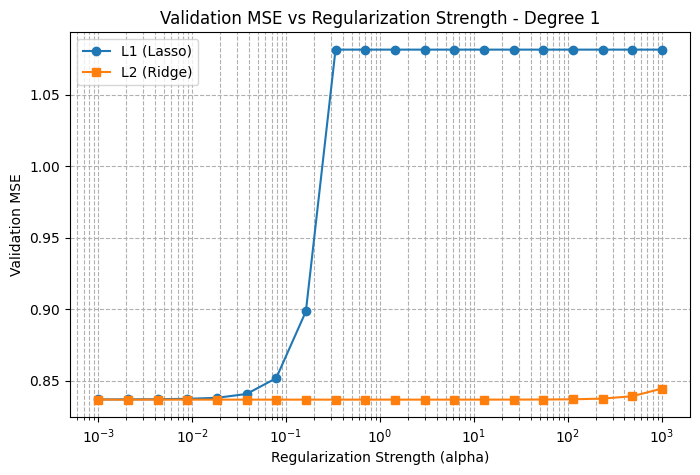

In [7]:
best_degree = None
min_val_mse = float('inf')

# For l1 and l2 iterate through all results, find the lease val_mse and corresponding index which gives degree
for reg in results:
    for d_idx, res in enumerate(results[reg]):
        if res['val_mse'] < min_val_mse:
            min_val_mse = res['val_mse']
            best_degree = degrees[d_idx]

print(f"Best degree based on validation MSE: {best_degree}")

reg_strengths = np.logspace(-3, 3, 20)
val_mses_l1 = []
val_mses_l2 = []

for alpha in reg_strengths:
    res_l1 = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                                 degree=best_degree, regularizer='l1', reg_strength=alpha)
    val_mses_l1.append(res_l1['val_mse'])

    res_l2 = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                                 degree=best_degree, regularizer='l2', reg_strength=alpha)
    val_mses_l2.append(res_l2['val_mse'])

plt.figure(figsize=(8, 5))
plt.semilogx(reg_strengths, val_mses_l1, marker='o', label='L1 (Lasso)')
plt.semilogx(reg_strengths, val_mses_l2, marker='s', label='L2 (Ridge)')
plt.xlabel("Regularization Strength (alpha)")
plt.ylabel("Validation MSE")
plt.title(f"Validation MSE vs Regularization Strength - Degree {best_degree}")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
